In [1]:
#Necessary Libraries
import pandas as pd 
import re 
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [3]:
fake=pd.read_csv("/kaggle/input/news-dataset/Fake.csv")
true=pd.read_csv("/kaggle/input/news-dataset/True.csv")


In [4]:
print(fake.head())
print(true.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

As we see we imported all the dataset succesfully.

In [5]:
true["rate"]=1 
fake["rate"]=0  

In [6]:
print(fake.head())
print(true.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  rate  
0  December 31, 2017     0  
1  December 31, 2017     0  
2  December 30, 2017     0  
3  December 29, 2017     0  
4  December 25, 2017     0  
                                               title  \
0  As U.S. budget fight looms, Republicans flip 

Additionally I've added a column named rate because we are going to classify which news is fake which is not so to show machine which one is which its essential at this point.

In [7]:
true.isnull().sum()

title      0
text       0
subject    0
date       0
rate       0
dtype: int64

No null values means no need to remove any column or row 
Now time to merge both fake and true csv files in a one file 

In [8]:
merged=pd.concat([true, fake], ignore_index=True)
print(merged.head())

                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  rate  
0  December 31, 2017      1  
1  December 29, 2017      1  
2  December 31, 2017      1  
3  December 30, 2017      1  
4  December 29, 2017      1  


Lets explore the dataset

In [9]:
#Counting how many news on every rate category
subject_counts=merged.groupby(["subject", "rate"]).size().reset_index(name="count")

print(subject_counts)

           subject  rate  count
0  Government News     0   1570
1      Middle-east     0    778
2             News     0   9050
3          US_News     0    783
4        left-news     0   4459
5         politics     0   6841
6     politicsNews     1  11272
7        worldnews     1  10145


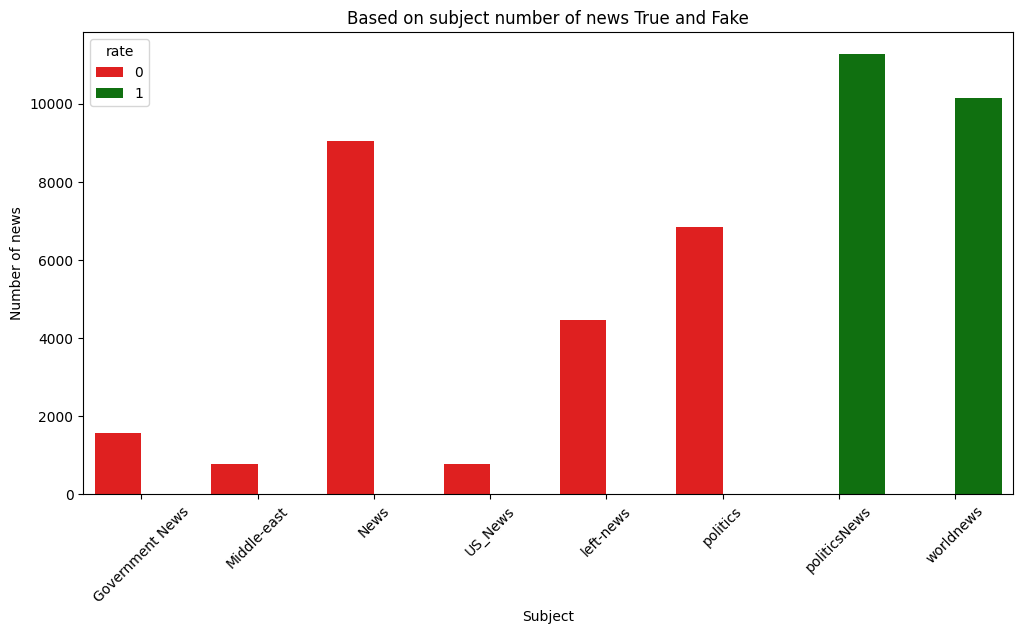

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=subject_counts,
    x="subject",
    y="count",
    hue="rate",
    palette={0: "red", 1: "green"}
)
plt.title("Based on subject number of news True and Fake")
plt.xlabel("Subject")
plt.ylabel("Number of news")
plt.xticks(rotation=45)
plt.show()

In [11]:
#Counting how distributed the fake and true news as a number
rate_counts=merged.groupby(["rate"]).size().reset_index(name="count")

print(rate_counts)

   rate  count
0     0  23481
1     1  21417


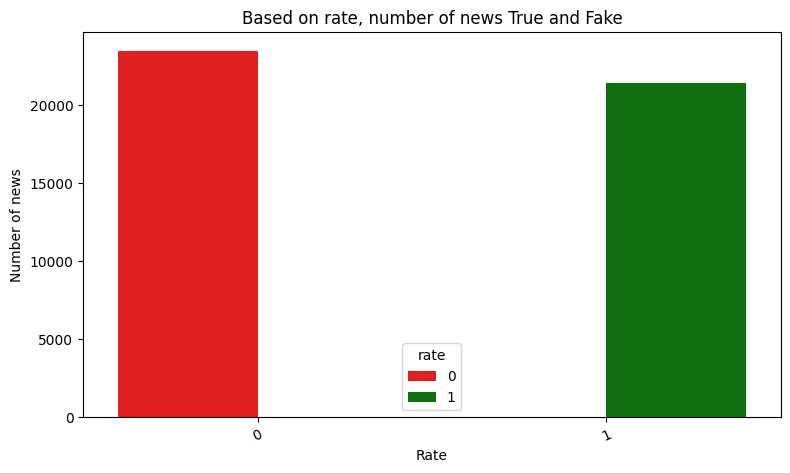

In [12]:
plt.figure(figsize=(9, 5))
sns.barplot(
    data=rate_counts,
    x="rate",
    y="count",
    hue="rate",
    palette={0: "red", 1: "green"}
)
plt.title("Based on rate, number of news True and Fake")
plt.xlabel("Rate")
plt.ylabel("Number of news")
plt.xticks(rotation=25)
plt.show()

In [13]:
necessary_words=[]
lemmatizer = WordNetLemmatizer()
for i in range (len(merged)):
    text = merged["text"].iloc[i]
    text=text.lower() #lowering all the letters 
    text= re.sub(r'[^\w\s]', '', text) #Removes the punctuations
    words=word_tokenize(text)
    tagged=pos_tag(words)#POS tagging
    lemmatized_words = []
    for word, tag in tagged:
        if tag.startswith('J'):
            pos = wordnet.ADJ
        elif tag.startswith('V'):
            pos = wordnet.VERB
        elif tag.startswith('N'):
            pos = wordnet.NOUN
        elif tag.startswith('R'):
            pos = wordnet.ADV
        else:
            pos = wordnet.NOUN  #for deafult noun
            
        lemma = lemmatizer.lemmatize(word, pos)
        lemmatized_words.append(lemma) 
    cleaned = " ".join(lemmatized_words)#brings together again
    necessary_words.append(cleaned)
    
merged["necessary_words"] = necessary_words

In the above part just made a processing and eliminated the unnecessary part in the title column
Also in the above part Ive added lemmatization part to increase model accuracy. It will significantly increase the time of process.

In [14]:
merged=merged.sample(frac=1, random_state=42).reset_index(drop=True)
#Shuffled the dataset because its not based on time series(historical)dataset
print(merged.head())

#Now checking is there any big mistakes

                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  rate                                    necessary_words  
0     July 21, 2017     0  donald trump s white house be in chaos and the...  
1       May 7, 2016     0  now that donald trump be the presumptive gop n...  
2  De

Very good we shuffled the dataset to decrease overfitting 

In [15]:
vectorizer = TfidfVectorizer(max_features=5000)#Most frequent 5000 words in dataset(TermFrequency)
X = vectorizer.fit_transform(merged["necessary_words"]).toarray()# X are the feature which we need is necessary_words column
y = merged["rate"] #y is our target which is rate column because model has to predict is entry 1 or 0 (True or fake)


In [16]:
#Splitting the dataset into train adn test sets .2 for test .8 for training
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Setting up the model and training
model=MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB()

In [18]:
#Time to make some test 
y_pred = model.predict(X_test)

# RESULTS

In [19]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9326280623608018
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4669
           1       0.93      0.93      0.93      4311

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

